# Stock Market Analysis

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
     

### Downloading Historical Market Data

In [2]:
# stock_data = yf.download('AAPL', start='2001-01-01')
stock_data = yf.download('AAPL', period='1y')
stock_data

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-24  180.669998  181.100006  176.009995  176.380005  175.482040   
2023-08-25  177.380005  179.149994  175.820007  178.610001  177.700699   
2023-08-28  180.089996  180.589996  178.550003  180.190002  179.272659   
2023-08-29  179.699997  184.899994  179.500000  184.119995  183.182632   
2023-08-30  184.940002  187.850006  184.740005  187.649994  186.694672   
...                ...         ...         ...         ...         ...   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   
2024-08-21  226.520004  227.979996  225.050003  226.399994  226.399994   
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   
2024-08-23  225.660004  228.220001  224.330002  226.839996  226.839996   

              Volume  
Date                  
2023-08-24  54945800  
2023-08-25  51449600  
2023-08-28  43820700  
2023-08-29  53003900  
2023-08-30  60813900  
...              ...  
2024-08-19  40687800  
2024-08-20  30299000  
2024-08-21  34765500  
2024-08-22  43695300  
2024-08-23  38629400  

[252 rows x 6 columns]

### Visualizung daily 'Open' price

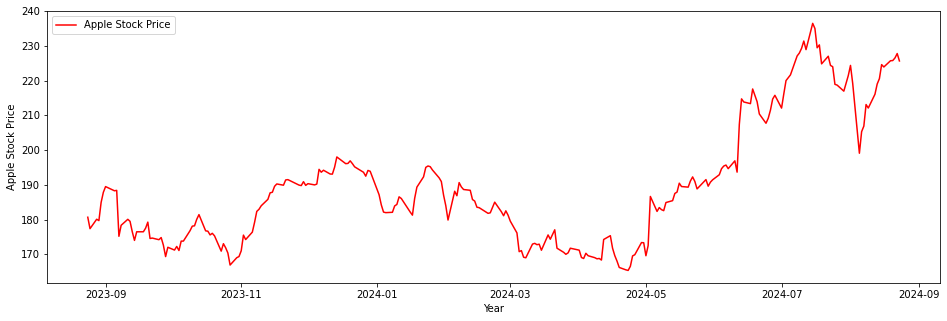

In [3]:
plt.figure(figsize=(16, 5))
ax = sns.lineplot(x="Date", y = "Open", data =stock_data, color= 'red', label = 'Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

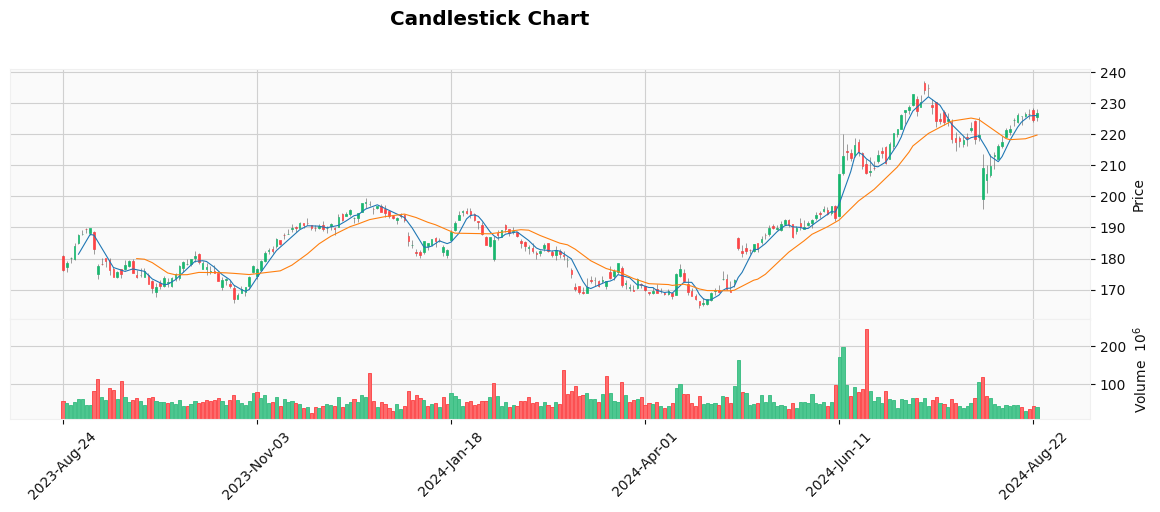

In [4]:
import mplfinance as mpf
stock_data_sample= stock_data.head(50)

# Plotting the candlestick chart
mpf.plot(stock_data, 
         type='candle', 
         style='yahoo', 
          mav=(5,20), 
         title='Candlestick Chart', 
         ylabel='Price', 
         volume=True,
        figsize=(15, 5))

### Identifying Support and Resistance 

[*********************100%%**********************]  1 of 1 completed
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


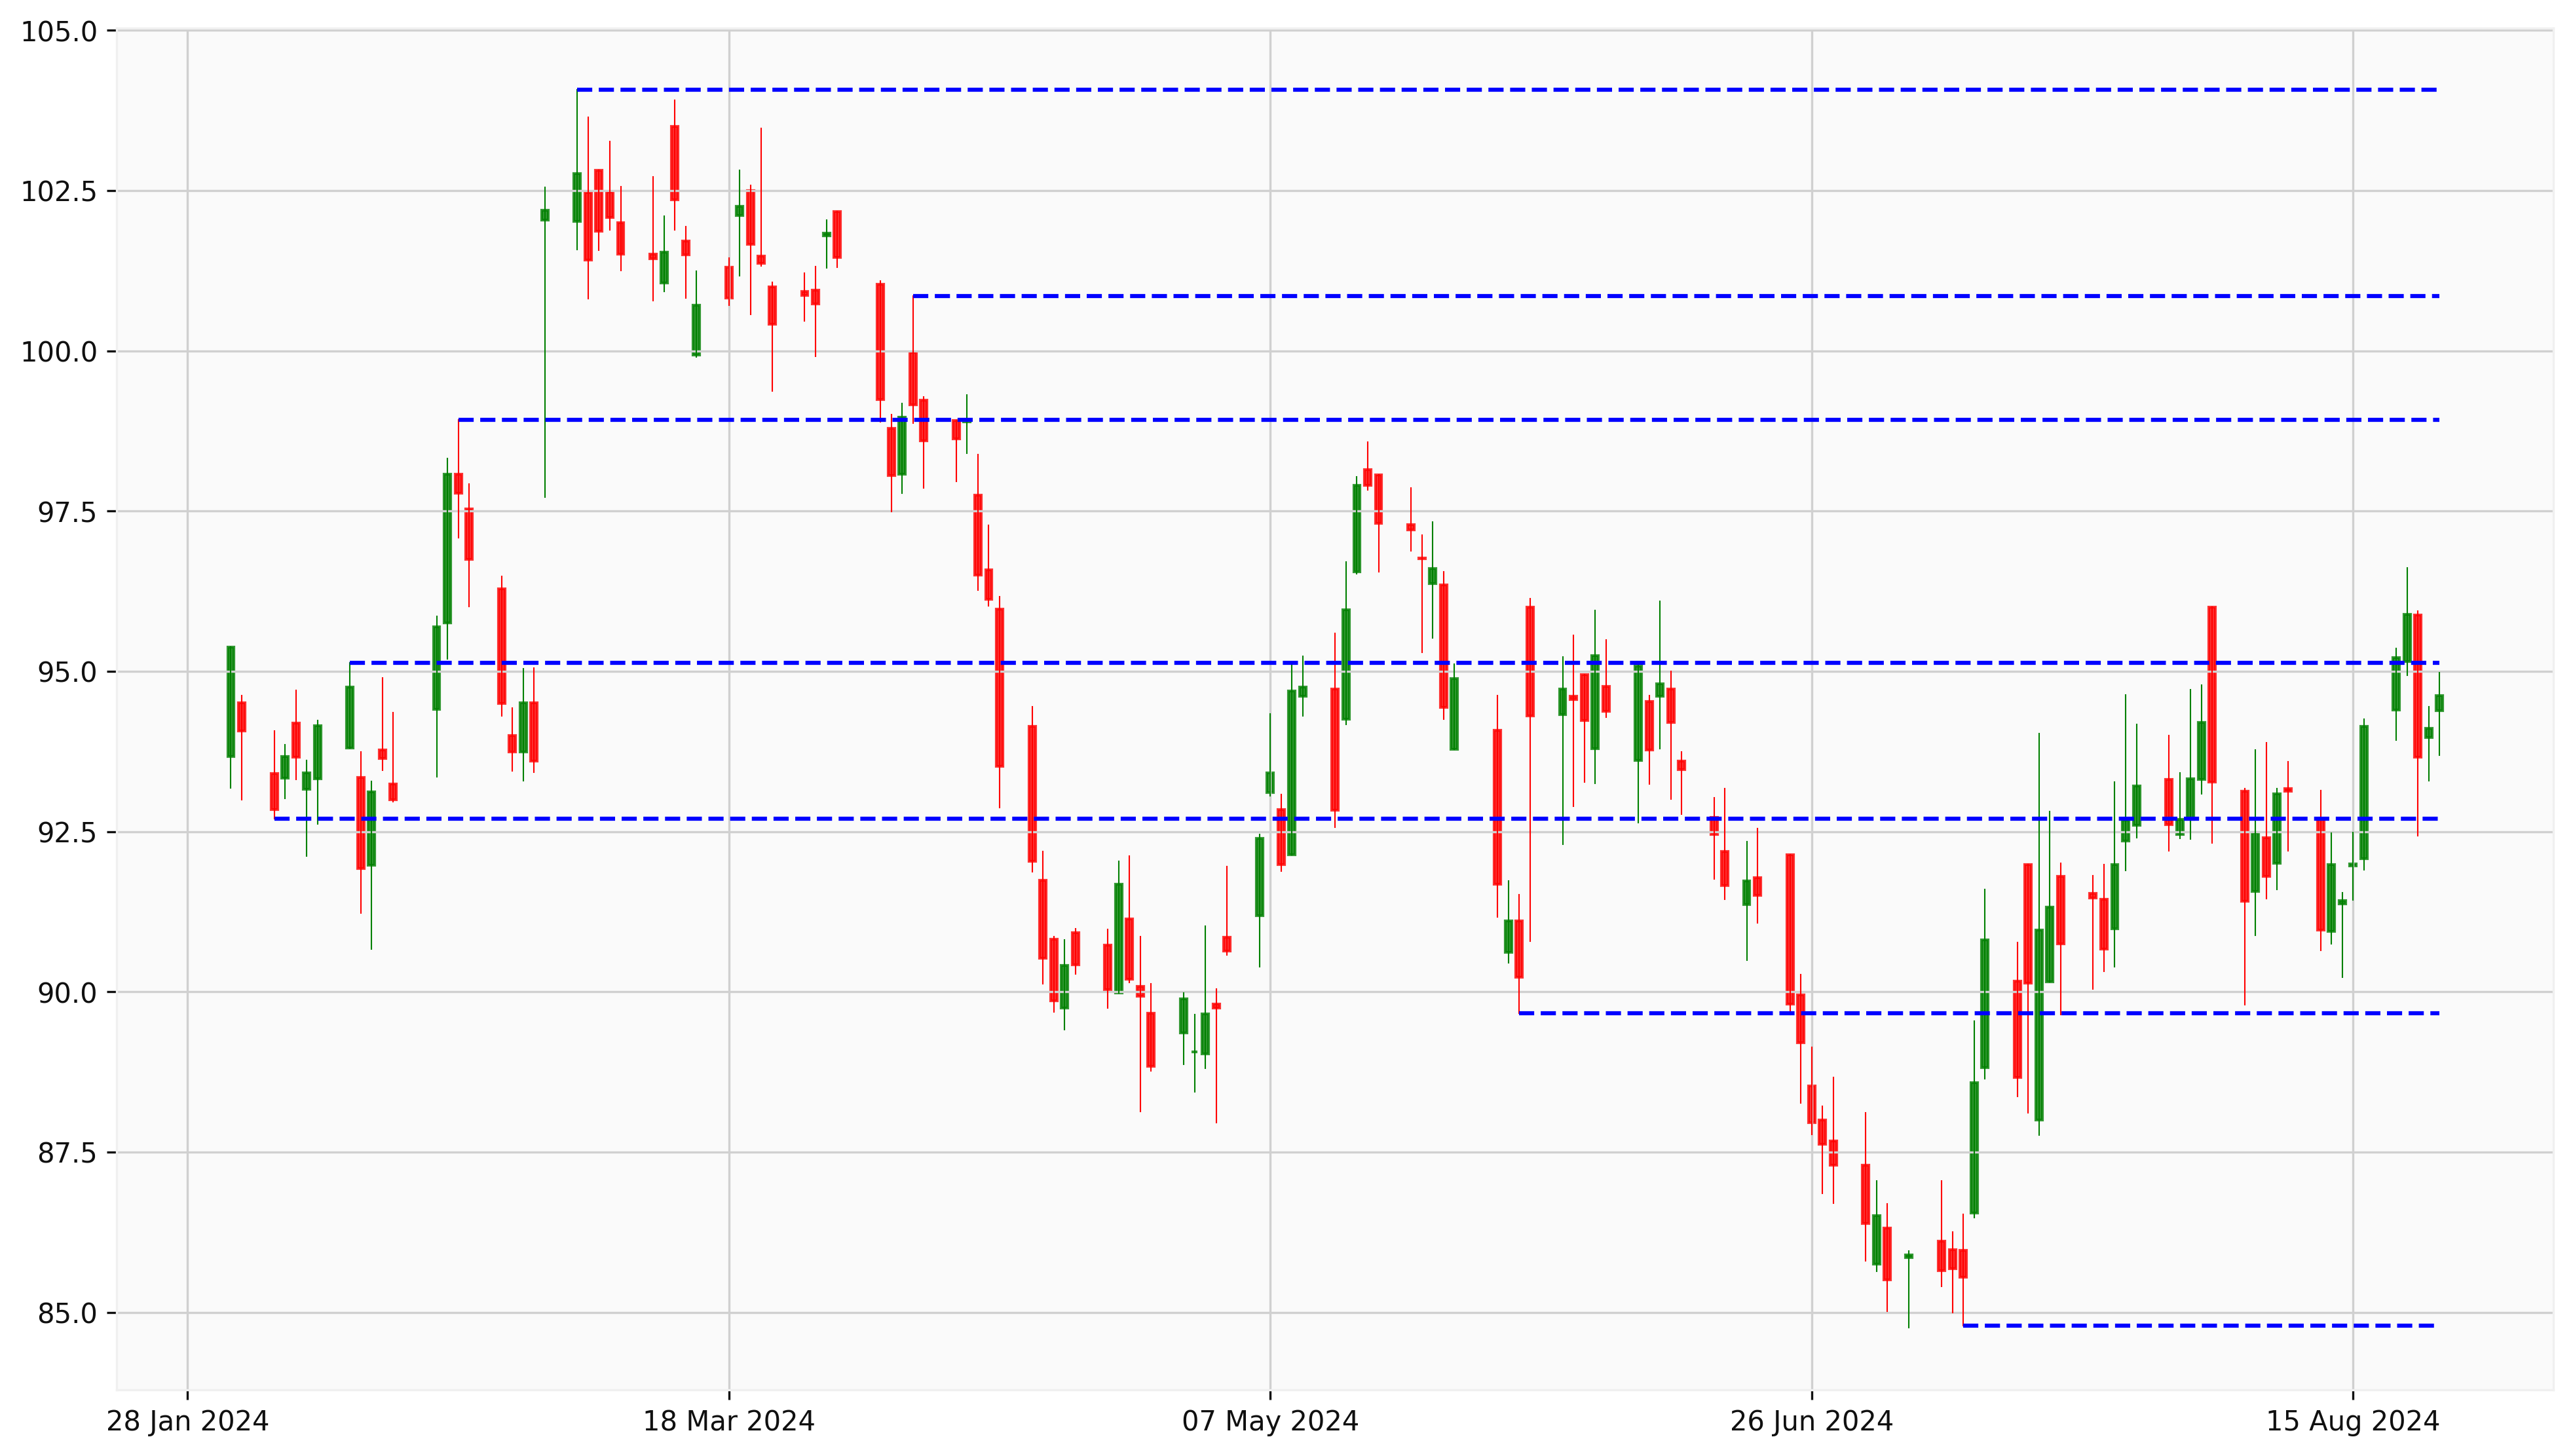

In [10]:
def get_stock_price(symbol):
  df = yf.download(symbol, start='2024-02-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  return df

def is_support(df,i):
  cond1 = df['Low'][i] < df['Low'][i-1] 
  cond2 = df['Low'][i] < df['Low'][i+1] 
  cond3 = df['Low'][i+1] < df['Low'][i+2] 
  cond4 = df['Low'][i-1] < df['Low'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_resistance(df,i):
  cond1 = df['High'][i] > df['High'][i-1] 
  cond2 = df['High'][i] > df['High'][i+1] 
  cond3 = df['High'][i+1] > df['High'][i+2] 
  cond4 = df['High'][i-1] > df['High'][i-2]
  return (cond1 and cond2 and cond3 and cond4)

def is_far_from_level(value, levels, df):
    ave =  np.mean(df['High'] - df['Low'])
    return np.sum([abs(value - level) < ave for _, level in levels]) == 0

def plot_all(levels, df):
    fig, ax = plt.subplots(figsize=(16, 9), dpi=300)
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    for level in levels:
        plt.hlines(level[1], xmin=df['Date'][level[0]], xmax=max(df['Date']), colors='blue', linestyle='--')
    fig.show()

stock_code = 'COO'
df = get_stock_price(stock_code)
levels = []
for i in range(2,len(df)-2):
  if is_support(df,i):
    l = df['Low'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))
  elif is_resistance(df,i):
    l = df['High'][i]
    if is_far_from_level(l, levels, df):
      levels.append((i,l))

plot_all(levels, df)


### Calculating Return on Investment from SuperTrend

In [11]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 10
atr_multiplier = 3.0

stock_list = ['AAPL']
for symbol in stock_list:
    df = yf.download(symbol, start='2020-01-01')
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    df = df.join(supertrend)
df.tail(15)

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-05  199.089996  213.500000  196.000000  209.270004  209.028061   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.990402   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.577423   
2024-08-08  213.110001  214.199997  208.830002  213.309998  213.063385   
2024-08-09  212.100006  216.779999  211.970001  216.240005  215.990005   
2024-08-12  216.070007  219.509995  215.600006  217.529999  217.529999   
2024-08-13  219.009995  221.889999  219.009995  221.270004  221.270004   
2024-08-14  220.570007  223.029999  219.699997  221.720001  221.720001   
2024-08-15  224.600006  225.350006  222.759995  224.720001  224.720001   
2024-08-16  223.919998  226.830002  223.649994  226.050003  226.050003   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   
2024-08-21  226.520004  227.979996  225.050003  226.399994  226.399994   
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   
2024-08-23  225.660004  228.220001  224.330002  226.839996  226.839996   

               Volume  Supertrend  Final Lowerband  Final Upperband  
Date                                                                 
2024-08-05  119548600       False              NaN       226.945295  
2024-08-06   69660500       False              NaN       226.945295  
2024-08-07   63516400       False              NaN       226.945295  
2024-08-08   47161100       False              NaN       226.945295  
2024-08-09   42201600       False              NaN       226.945295  
2024-08-12   38028100       False              NaN       226.945295  
2024-08-13   44155300       False              NaN       226.945295  
2024-08-14   41960600       False              NaN       226.945295  
2024-08-15   46414000       False              NaN       226.945295  
2024-08-16   44340200       False              NaN       226.945295  
2024-08-19   40687800       False              NaN       226.945295  
2024-08-20   30299000       False              NaN       226.945295  
2024-08-21   34765500       False              NaN       226.945295  
2024-08-22   43695300       False              NaN       226.945295  
2024-08-23   38629400       False              NaN       226.945295

In [27]:
import matplotlib.pyplot as plt

# Visualization with an improved color scheme
plt.figure(figsize=(10, 4), dpi=100)

# Change the color scheme for better contrast and visualization
plt.plot(df['Close'], color='navy', linewidth=1, label='Close Price')
plt.plot(df['Final Lowerband'], color='limegreen', linewidth=1.5, label='Final Lowerband')
plt.plot(df['Final Upperband'], color='tomato', linewidth=1.5, label='Final Upperband')

# Adding title, labels, and legend for better clarity
plt.title('Close Price with Final Lower and Upper Bands', fontsize=7)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Price', fontsize=8)
plt.legend(loc='best', fontsize=8)

# Show the plot
plt.show()


### Applying above indicator on Apple stock

In [28]:
# backtesting

def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, roi
entry, exit, roi = backtest_supertrend(df, 100000)

Buy 1300 shares at 74.95 on 2020/01/06
Sell at 74.54 on 2020/02/24
Buy 1300 shares at 71.76 on 2020/04/14
Sell at 120.88 on 2020/09/03
Buy 1300 shares at 124.4 on 2020/10/12
Sell at 108.86 on 2020/10/30
Buy 1100 shares at 122.72 on 2020/12/01
Sell at 129.71 on 2021/02/18
Buy 1100 shares at 130.36 on 2021/04/08
Sell at 126.85 on 2021/05/10
Buy 1100 shares at 131.79 on 2021/06/17
Sell at 148.12 on 2021/09/14
Buy 1100 shares at 148.76 on 2021/10/19
Sell at 166.23 on 2022/01/19
Buy 1000 shares at 174.78 on 2022/01/31
Sell at 160.07 on 2022/02/23
Buy 1000 shares at 168.82 on 2022/03/22
Sell at 165.29 on 2022/04/14
Buy 1100 shares at 146.35 on 2022/07/07
Sell at 163.62 on 2022/08/26
Buy 1200 shares at 152.34 on 2022/10/25
Sell at 134.87 on 2022/11/09
Buy 1100 shares at 141.11 on 2023/01/23
Sell at 181.99 on 2023/08/04
Buy 1100 shares at 184.12 on 2023/08/29
Sell at 177.56 on 2023/09/07
Buy 1100 shares at 179.23 on 2023/11/06
Sell at 185.64 on 2024/01/02
Buy 1000 shares at 191.56 on 2024/01/1

### Visualizing Points where buy/sell occured

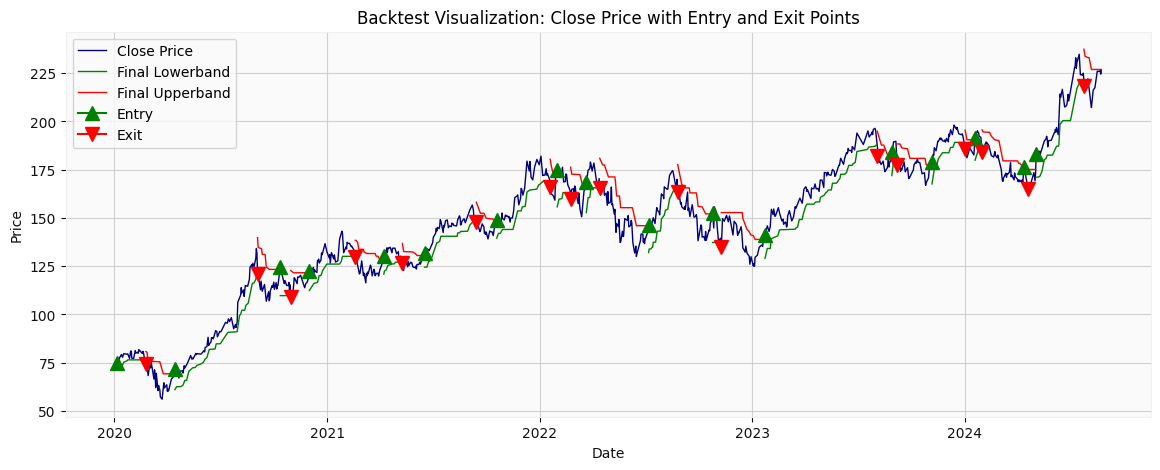

In [47]:
#  visualization (for backtest)


import matplotlib.pyplot as plt

# Visualization for backtest
plt.figure(figsize=(14, 5), dpi=100)

# Plot the Lowerband and Upperband
plt.plot(df['Close'], color='navy', linewidth=1, label='Close Price')
plt.plot(df['Final Lowerband'], color='green', linewidth=1, label='Final Lowerband')
plt.plot(df['Final Upperband'], color='red', linewidth=1, label='Final Upperband')

# Plot entry and exit points with distinct markers
for i, e in enumerate(entry):
    if i == 0:
        plt.plot(df.index[e[0]], e[1], marker='^', color='green', markersize=10, label='Entry')
    else:
        plt.plot(df.index[e[0]], e[1], marker='^', color='green', markersize=10)

for i, e in enumerate(exit):
    if i == 0:
        plt.plot(df.index[e[0]], e[1], marker='v', color='red', markersize=10, label='Exit')
    else:
        plt.plot(df.index[e[0]], e[1], marker='v', color='red', markersize=10)

# Enhance plot with title, labels, and legend
plt.title('Backtest Visualization: Close Price with Entry and Exit Points', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend(loc='best', fontsize=10)

# Show the plot
plt.show()


### Finding Optimal Parameter on Supertrend for Tesla Stock

In [143]:
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0]

    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])

df = yf.download('TSLA', start='2010-01-01')
optimal_param = find_optimal_parameter(df)

print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')

[*********************100%%**********************]  1 of 1 completed


Earning from investing $100k is $2411199.01 (ROI = 2411.2%)
Earning from investing $100k is $2573421.83 (ROI = 2573.42%)
Earning from investing $100k is $3502401.19 (ROI = 3502.4%)
Earning from investing $100k is $8436627.45 (ROI = 8436.63%)
Earning from investing $100k is $3127076.62 (ROI = 3127.08%)
Earning from investing $100k is $1772137.79 (ROI = 1772.14%)
Earning from investing $100k is $1568913.71 (ROI = 1568.91%)
Earning from investing $100k is $3420075.54 (ROI = 3420.08%)
Earning from investing $100k is $6469262.22 (ROI = 6469.26%)
Earning from investing $100k is $3056036.58 (ROI = 3056.04%)
Earning from investing $100k is $1293089.65 (ROI = 1293.09%)
Earning from investing $100k is $1577337.38 (ROI = 1577.34%)
Earning from investing $100k is $2635372.51 (ROI = 2635.37%)
Earning from investing $100k is $6017545.52 (ROI = 6017.55%)
Earning from investing $100k is $3642198.51 (ROI = 3642.2%)
Earning from investing $100k is $1403267.02 (ROI = 1403.27%)
Earning from investing $100

### Analysing Yearly Growth

[*********************100%%**********************]  1 of 1 completed


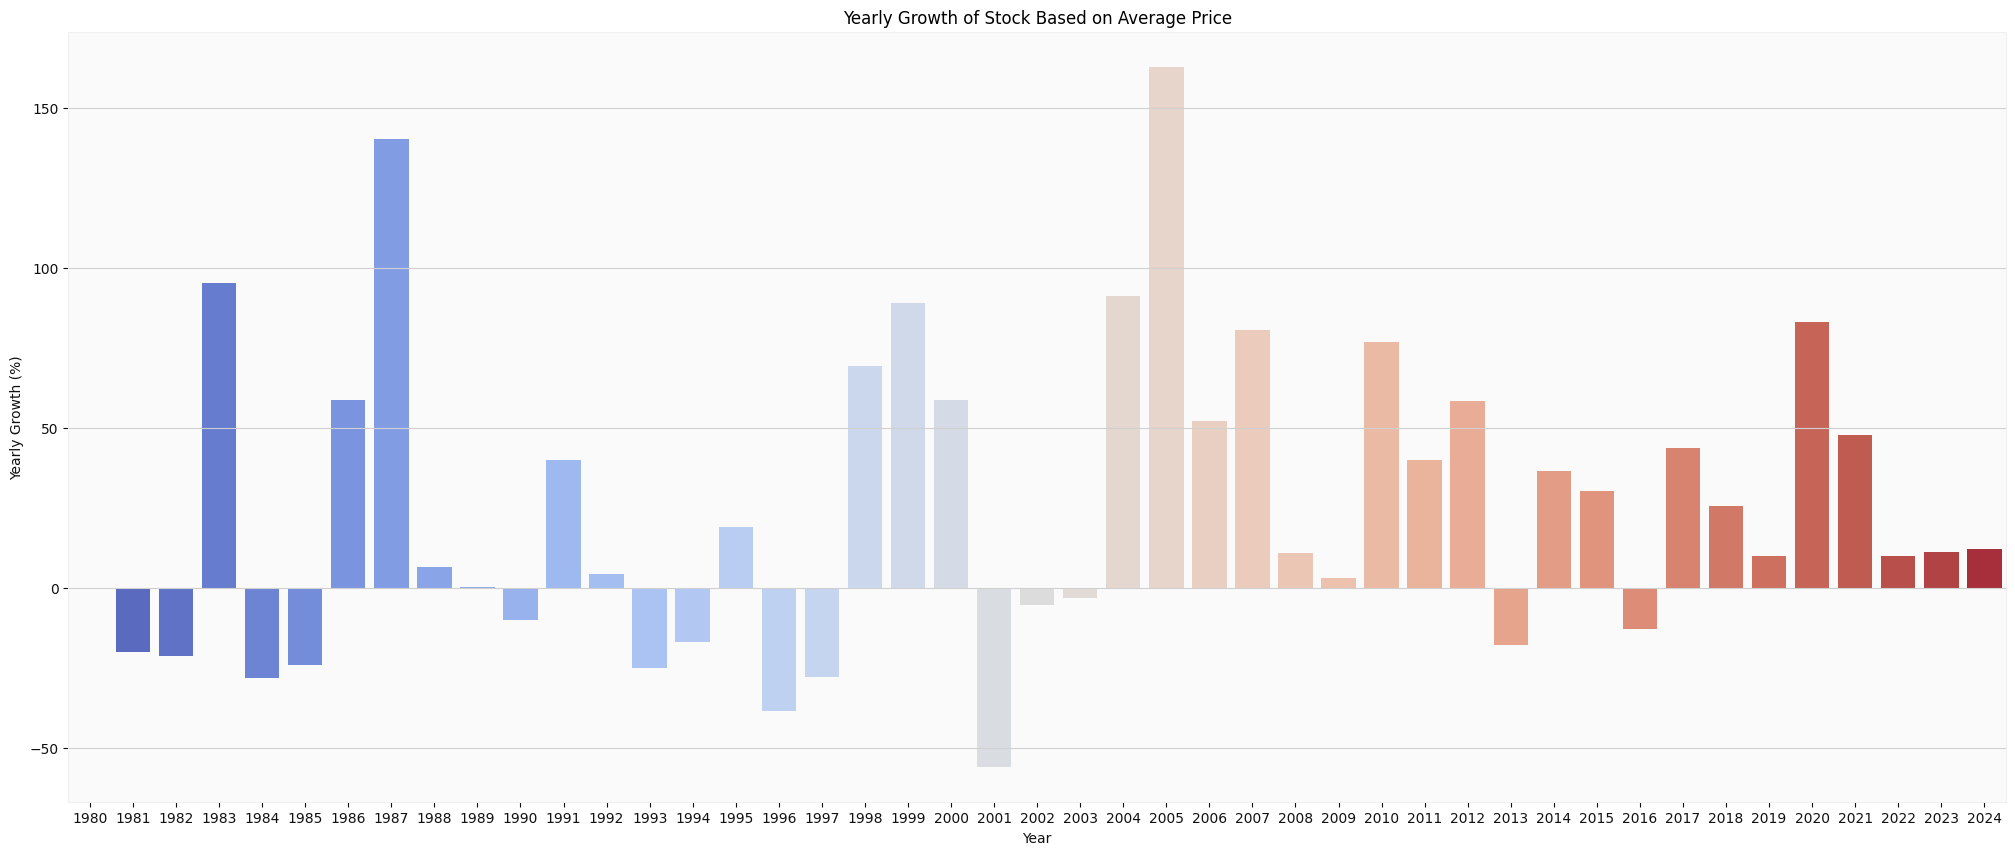

In [48]:
stock_data = yf.download('AAPL', period='max')
stock_data.index = pd.to_datetime(stock_data.index)

# Extract the year from the date index
stock_data['Year'] = stock_data.index.year


stock_data['Average Price'] = stock_data[['Open', 'High', 'Low']].mean(axis=1)
yearly_data = stock_data.groupby('Year')['Average Price'].mean()

# Calculate the yearly growth (percentage change)
yearly_growth = yearly_data.pct_change() * 100

# Rename the column for clarity
yearly_growth = yearly_growth.rename('Yearly Growth (%)')

# Display the yearly growth for each year
# print(yearly_growth)

# Optionally, plot the yearly growth
plt.figure(figsize=(25, 10))
sns.barplot(x=yearly_growth.index, y=yearly_growth.values, palette='coolwarm')
plt.title('Yearly Growth of Stock Based on Average Price')
plt.xlabel('Year')
plt.ylabel('Yearly Growth (%)')
plt.show()


### Indicators in ta(technical analysis ) Library  

In [49]:
import pandas_ta as ta

df = pd.DataFrame()
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

### Creating Targets

In [50]:
stock_data = yf.download('AAPL', period='max')
lookahead_period = 10
# Calculate the log returns
targets = stock_data.ta.log_return(cumulative=False, append=False, length=lookahead_period)

# Convert to DataFrame and rename columns
target_df = pd.DataFrame(targets)
target_df.columns = [f"TARGET_{c}" for c in target_df.columns]

# Shift the target DataFrame by the lookahead period + 1
target_df = target_df.shift(-lookahead_period - 1)

# Join the new targets with the original OHLC DataFrame
stock_data = stock_data.join(target_df)

# Display the updated DataFrame
stock_data

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.098943   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.093781   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.086898   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089049   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091630   
...                ...         ...         ...         ...         ...   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   
2024-08-21  226.520004  227.979996  225.050003  226.399994  226.399994   
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   
2024-08-23  225.660004  228.220001  224.330002  226.839996  226.839996   

               Volume  TARGET_LOGRET_10  
Date                                     
1980-12-12  469033600          0.253858  
1980-12-15  175884800          0.301208  
1980-12-16  105728000          0.287686  
1980-12-17   86441600          0.237129  
1980-12-18   73449600          0.132424  
...               ...               ...  
2024-08-19   40687800               NaN  
2024-08-20   30299000               NaN  
2024-08-21   34765500               NaN  
2024-08-22   43695300               NaN  
2024-08-23   38629400               NaN  

[11016 rows x 7 columns]

### Creating Features

In [51]:
lookback_periods = [5, 10, 100, 500]
for lookback_period in lookback_periods:
    feature_types = ta.Strategy(
        name=f"features_{lookback_period}", 
        ta=[
            {"kind": "sma", "length": lookback_period},
            {"kind": "rsi", "length": lookback_period},
            {"kind": "stdev", "length": lookback_period},
            {"kind": "supertrend", "length": lookback_period},
            {"kind": "macd", "length": lookback_period},
        ])
    stock_data.ta.strategy(feature_types)
stock_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.098943   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.093781   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.086898   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089049   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091630   
...                ...         ...         ...         ...         ...   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   
2024-08-21  226.520004  227.979996  225.050003  226.399994  226.399994   
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   
2024-08-23  225.660004  228.220001  224.330002  226.839996  226.839996   

               Volume  TARGET_LOGRET_10       SMA_5      RSI_5   STDEV_5  ...  \
Date                                                                      ...   
1980-12-12  469033600          0.253858         NaN        NaN       NaN  ...   
1980-12-15  175884800          0.301208         NaN        NaN       NaN  ...   
1980-12-16  105728000          0.287686         NaN        NaN       NaN  ...   
1980-12-17   86441600          0.237129         NaN        NaN       NaN  ...   
1980-12-18   73449600          0.132424    0.119420        NaN  0.006023  ...   
...               ...               ...         ...        ...       ...  ...   
2024-08-19   40687800               NaN  223.930002  78.544958  2.286908  ...   
2024-08-20   30299000               NaN  224.978000  80.150125  1.937076  ...   
2024-08-21   34765500               NaN  225.913998  78.841953  0.713461  ...   
2024-08-22   43695300               NaN  225.875998  58.538918  0.793522  ...   
2024-08-23   38629400               NaN  226.033997  70.334829  0.907319  ...   

            SUPERTd_100_3.0  SUPERTl_100_3.0  SUPERTs_100_3.0    SMA_500  \
Date                                                                       
1980-12-12                1              NaN              NaN        NaN   
1980-12-15                1              NaN              NaN        NaN   
1980-12-16                1              NaN              NaN        NaN   
1980-12-17                1              NaN              NaN        NaN   
1980-12-18                1              NaN              NaN        NaN   
...                     ...              ...              ...        ...   
2024-08-19                1       212.417972              NaN  174.22462   
2024-08-20                1       213.602132              NaN  174.34318   
2024-08-21                1       213.846313              NaN  174.46092   
2024-08-22                1       213.846313              NaN  174.56992   
2024-08-23                1       213.846313              NaN  174.69636   

              RSI_500  STDEV_500  SUPERT_500_3.0  SUPERTd_500_3.0  \
Date                                                                
1980-12-12        NaN        NaN        0.000000                1   
1980-12-15        NaN        NaN             NaN                1   
1980-12-16        NaN        NaN             NaN                1   
1980-12-17        NaN        NaN             NaN                1   
1980-12-18        NaN        NaN             NaN                1   
...               ...        ...             ...              ...   
2024-08-19  53.745834  23.036947      214.857853                1   
2024-08-20  53.776195  23.153127      215.940996                1   
2024-08-21  53.769920  23.267811      216.149156                1   
2024-08-22  53.663265  23.374423      216.149156                1   
2024-08-23  53.776752  23.485797      216.149156                1   

            SUPERTl_500_3.0  SUPERTs_500_3.0  
Date                                          
1980-12-12          

In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11014 entries, 1980-12-12 to 2024-08-21
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              11014 non-null  float64
 1   High              11014 non-null  float64
 2   Low               11014 non-null  float64
 3   Close             11014 non-null  float64
 4   Adj Close         11014 non-null  float64
 5   Volume            11014 non-null  int64  
 6   TARGET_LOGRET_10  11003 non-null  float64
 7   SMA_5             11010 non-null  float64
 8   RSI_5             11009 non-null  float64
 9   STDEV_5           11010 non-null  float64
 10  SUPERT_5_3.0      11010 non-null  float64
 11  SUPERTd_5_3.0     11014 non-null  int64  
 12  SUPERTl_5_3.0     5979 non-null   float64
 13  SUPERTs_5_3.0     5030 non-null   float64
 14  MACD_12_26_9      10989 non-null  float64
 15  MACDh_12_26_9     10981 non-null  float64
 16  MACDs_12_26_9     10981

### LightGBM Model for Regression

In [54]:
features_cols = stock_data.columns[stock_data.columns.str.contains("TARGET") == False]
features = stock_data[features_cols]
# features.describe()

target_col = "TARGET_LOGRET_10"
targets = stock_data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11016 entries, 1980-12-12 to 2024-08-23
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TARGET_LOGRET_10  11005 non-null  float64
dtypes: float64(1)
memory usage: 430.2 KB


In [55]:
import lightgbm as lgb
import pandas.util.testing as tm
data = stock_data
size = 1000
target_col = "TARGET_LOGRET_10"
y = targets[[target_col]].head(size)
X = features.head(size)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)


#### train
# list of params: https://lightgbm.readthedocs.io/en/latest/Parameters.html
# no cross validation
lgb_train = lgb.Dataset(data=X_train,
                   label=y_train,
                   free_raw_data=False # it is to release memory and only using it when training (if True you cant see data)
                   )

lgb_valid = lgb.Dataset(data=X_valid,
                   label=y_valid,
                   free_raw_data=False)
evals_result = {}
 
params = { 
    "objective": "regression",
    "metric": ('l1', 'l2'), # mean absolute error, and mean squared error
    
    "num_iterations": 100, # alias for numbef of trees
    # "learning_rate": 0.01, # it is for the contribution of each tree to final result and find the best W s
    
    "max_depth": 20,
    "num_leaves": 10,
    "min_data_in_leaf": 5,
    "feature_fraction": 0.3,

    "learning_rate" : 0.01
    
    }

model = lgb.train(params=params,
                  train_set=lgb_train,
                  valid_sets=[lgb_valid, lgb_train],
                  callbacks=[
                    lgb.log_evaluation(10),
                    lgb.record_evaluation(evals_result),
                    lgb.early_stopping(stopping_rounds=5)
                ]
)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6040
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 37
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.000227
Training until validation scores don't improve for 5 rounds
[10]	training's l1: 0.0870029	training's l2: 0.0123181	valid_0's l1: 0.0849888	valid_0's l2: 0.0118919
[20]	training's l1: 0.0846346	training's l2: 0.0115802	valid_0's l1: 0.0831639	valid_0's l2: 0.0113569
[30]	training's l1: 0.082422	training's l2: 0.010907	valid_0's l1: 0.0814493	valid_0's l2: 0.0108262
[40]	training's l1: 0.080366	training's l2: 0.0103288	valid_0's l1: 0.0799092	valid_0's l2: 0.0104275
[50]	training's l1: 0.0784754	t

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

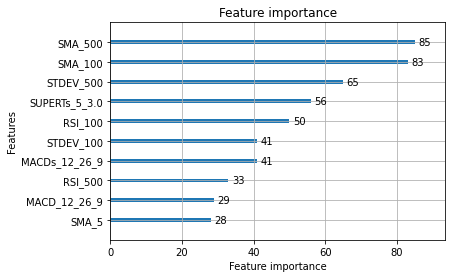

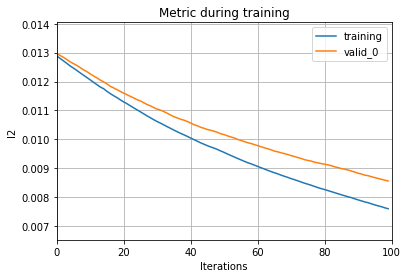

In [44]:
lgb.plot_importance(model, max_num_features=10)
lgb.plot_metric(evals_result, metric='l2')

In [45]:
# prediction
from sklearn.metrics import mean_squared_error
y_preds = model.predict(X)
mean_squared_error(y, y_preds) ** 0.5

0.0882505873435066

### Training Neural Network for Regression on Scaled Data Using Keras

In [57]:
from sklearn.preprocessing import scale

data=stock_data

excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_10"
targets = data[[target_col]]
targets.info()

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11016 entries, 1980-12-12 to 2024-08-23
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TARGET_LOGRET_10  11005 non-null  float64
dtypes: float64(1)
memory usage: 430.2 KB


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

### Make alterations to improve score

In [61]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are originally pandas DataFrames or Series
X = features[features.columns[:3]].head(2000).to_numpy()  # Convert to numpy array
y = targets.head(2000).to_numpy()  # Convert to numpy array

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check for NaNs and handle them
print("NaNs in X_scaled:", np.isnan(X_scaled).sum())
print("NaNs in y:", np.isnan(y).sum())

X_scaled = np.nan_to_num(X_scaled, nan=0.0)
y = np.nan_to_num(y, nan=0.0)

# Build the model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(3,)))
model.add(Dense(1, activation='linear'))  # Regression usually uses 'linear'

# Compile the model
model.compile(loss="mean_squared_error", 
              optimizer='adam', 
              metrics=["mean_absolute_error"])

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Train the model
history = model.fit(X_scaled, 
                    y, 
                    epochs=100, 
                    validation_split=0.3, 
                    verbose=0, 
                    batch_size=256,
                    callbacks=[early_stop]
                   )

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
history_df.index.name = "epoch"



NaNs in X_scaled: 4
NaNs in y: 0


In [66]:
# Plotting the history
plt.figure(figsize=(7,3))
sns.lineplot(data=history_df)
plt.show()

In [42]:
model.predict(X)

63/63 [==============================] - 0s 2ms/step


array([[        nan],
       [        nan],
       [        nan],
       ...,
       [-0.11470398],
       [-0.10045037],
       [-0.11407535]], dtype=float32)

### Testing 2010 to 2020 and predicting 2021 to 2024

In [43]:
tesla_stock = yf.download('TSLA', start='2010-01-01')
df= tesla_stock
df

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2024-08-15  205.020004  215.880005  204.820007  214.139999  214.139999   
2024-08-16  211.149994  219.800003  210.800003  216.119995  216.119995   
2024-08-19  217.070007  222.979996  214.089996  222.720001  222.720001   
2024-08-20  224.880005  228.220001  219.559998  221.100006  221.100006   
2024-08-21  222.669998  224.660004  218.860001  223.270004  223.270004   

               Volume  
Date                   
2010-06-29  281494500  
2010-06-30  257806500  
2010-07-01  123282000  
2010-07-02   77097000  
2010-07-06  103003500  
...               ...  
2024-08-15   89848500  
2024-08-16   88765100  
2024-08-19   76435200  
2024-08-20   74001200  
2024-08-21   70003100  

[3561 rows x 6 columns]

In [46]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label='Close', color='blue', alpha=0.5)

### predicting closing price

In [71]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


In [73]:
# Load and preprocess the data
data = df.filter(['Close'])
dataset = data.values

# Get the number of rows to train the model on (80% of the dataset)
training_data_len = math.ceil(len(dataset) * .8)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Define the number of days to base predictions on (10 years)
prediction_window = 2520

# Create the training dataset
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(prediction_window, len(train_data)):
    x_train.append(train_data[i - prediction_window:i, 0])
    y_train.append(train_data[i, 0])
    if i <= prediction_window:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into 3 dimensions (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.        , 0.00027063, 0.00026085, ..., 0.2240163 , 0.22010679,
       0.22473691])]
[0.24925209510765334]



In [77]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(13))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=5)



Epoch 1/5
32/32 [==============================] - 165s 5s/step - loss: 0.0663
Epoch 2/5
32/32 [==============================] - 148s 5s/step - loss: 0.0062
Epoch 3/5
32/32 [==============================] - 150s 5s/step - loss: 0.0041
Epoch 4/5
32/32 [==============================] - 148s 5s/step - loss: 0.0027
Epoch 5/5
32/32 [==============================] - 153s 5s/step - loss: 0.0022


In [79]:
# Create the test dataset
test_data = scaled_data[training_data_len - prediction_window:, :]

# Create the x_test and y_test datasets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(prediction_window, len(test_data)):
    x_test.append(test_data[i - prediction_window:i, 0])

# Convert the x_test to a numpy array
x_test = np.array(x_test)

# Reshape the data into 3 dimensions (samples, timesteps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions


23/23 [==============================] - 18s 787ms/step


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


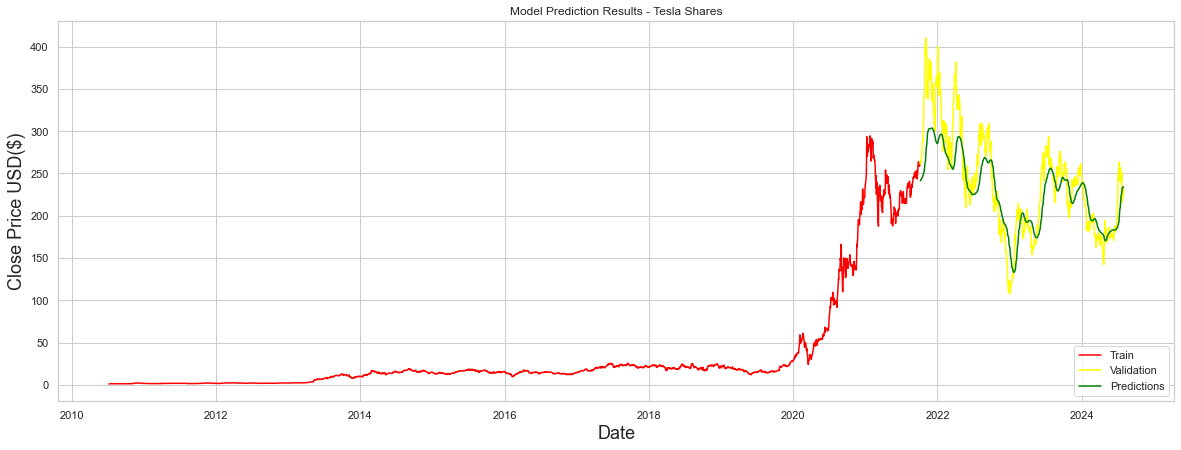

In [83]:
# Visualize the data
plt.figure(figsize=(20,7))
plt.title('Model Prediction Results - Tesla Shares')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'], color='red')
plt.plot(valid['Close'], color='yellow')
plt.plot(valid['predictions'], color='green')
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

### Linear Regression

In [152]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame and 'Date' is already set as the index
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# Calculate Simple Interest Daily Return
df['simple_interest_daily_return'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)

lookahead= 5
# Create a new column for the lookahead log return
df['lookahead_log_return'] = df['log_return'].shift(-lookahead)

# Drop rows with NaN values (resulting from the shift)
df = df.dropna()

df

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
2010-07-14    1.196000    1.343333    1.184000    1.322667    1.322667   
2010-07-15    1.329333    1.433333    1.266667    1.326000    1.326000   
...                ...         ...         ...         ...         ...   
2024-07-11  263.299988  271.000000  239.649994  241.029999  241.029999   
2024-07-12  235.800003  251.839996  233.089996  248.229996  248.229996   
2024-07-15  255.970001  265.600006  251.729996  252.639999  252.639999   
2024-07-16  255.309998  258.619995  245.800003  256.559998  256.559998   
2024-07-17  252.729996  258.470001  246.179993  248.500000  248.500000   

               Volume  log_return  lookahead_log_return  \
Date                                                      
2010-07-09   60759000   -0.003442              0.037014   
2010-07-12   33037500   -0.020320              0.059712   
2010-07-13   40201500    0.061969             -0.076323   
2010-07-14   62928000    0.089581             -0.003948   
2010-07-15   56097000    0.002517              0.037850   
...               ...         ...                   ...   
2024-07-11  221707300   -0.088221              0.002933   
2024-07-12  155955800    0.029434             -0.041076   
2024-07-15  146912900    0.017610              0.050183   
2024-07-16  126332500    0.015397             -0.020608   
2024-07-17  115584800   -0.031920             -0.131643   

            simple_interest_daily_return  
Date                                      
2010-07-09                     -0.003436  
2010-07-12                     -0.020115  
2010-07-13                      0.063929  
2010-07-14                      0.093716  
2010-07-15                      0.002520  
...                                  ...  
2024-07-11                     -0.084441  
2024-07-12                      0.029872  
2024-07-15                      0.017766  
2024-07-16                      0.015516  
2024-07-17                     -0.031416  

[3529 rows x 9 columns]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


<AxesSubplot:xlabel='simple_interest_daily_return', ylabel='Density'>

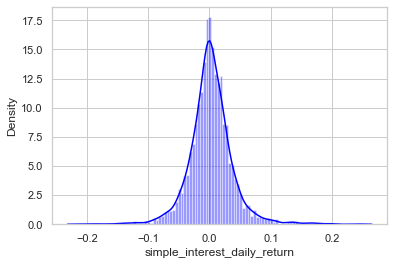

In [153]:
# plt.plot(df.index, df['simple_interest_daily_return'], label='Close', color='blue', alpha=0.5)
sns.distplot(df['simple_interest_daily_return'].dropna(),bins=100,color='blue')

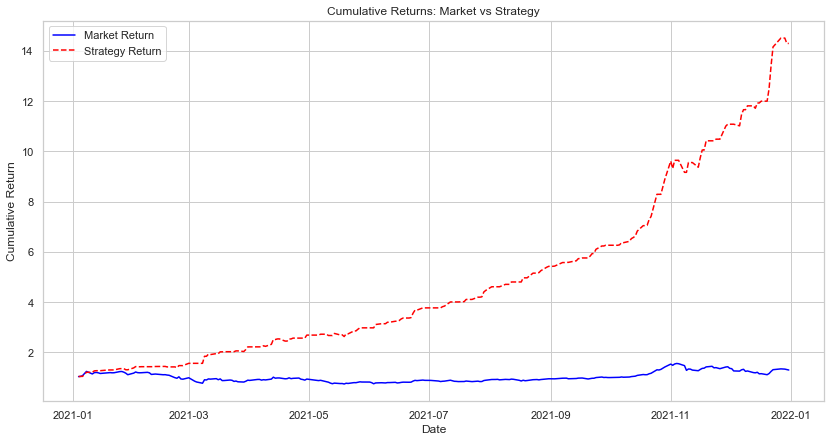

Final Cumulative Market Return: 1.29
Final Cumulative Strategy Return: 14.30
            Actual Return  Predicted Return  Signal  Strategy Return  \
Date                                                                   
2021-01-04       0.033582          0.022495       1         0.033582   
2021-01-05       0.007291          0.042844       1         0.007291   
2021-01-06       0.027995         -0.019252       0         0.000000   
2021-01-07       0.076448          0.142143       1         0.076448   
2021-01-08       0.075481          0.103514       1         0.075481   

            Cumulative Market Return  Cumulative Strategy Return  
Date                                                              
2021-01-04                  1.033582                    1.033582  
2021-01-05                  1.041117                    1.041117  
2021-01-06                  1.070263                    1.041117  
2021-01-07                  1.152083                    1.120709  
2021-01-08      

In [159]:
# Ensure the train/test split is correct and aligned with the indices of the original DataFrame
train_data = df.loc[train_start:train_end]
test_data = df.loc[test_start:test_end]

# Separate features and target
X_train = train_data[['Open', 'High', 'Close',  'Low']]
y_train = train_data['log_return']
X_test = test_data[['Open', 'High', 'Close',  'Low']]
y_test = test_data['log_return']

# Ensure that the lengths of y_test and X_test match
assert len(y_test) == len(X_test), "Mismatch between test data lengths!"

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Ensure that the length of y_pred matches y_test
assert len(y_pred) == len(y_test), "Mismatch between predicted and actual values!"

# Combine predictions with actual data for better visualization
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Ensure no mismatch occurs in the index lengths
assert len(result) == len(y_test), "Mismatch between result DataFrame and y_test!"

# Continue with the previous steps
result['Signal'] = np.where(result['Predicted'] > 0, 1, 0)  # 1 for Buy, 0 for Sell

# Strategy evaluation and plotting as before
strategy = pd.DataFrame(index=result.index)
strategy['Actual Return'] = y_test
strategy['Predicted Return'] = y_pred
strategy['Signal'] = result['Signal']

strategy['Strategy Return'] = strategy['Signal'] * strategy['Actual Return']

strategy['Cumulative Market Return'] = (1 + strategy['Actual Return']).cumprod()
strategy['Cumulative Strategy Return'] = (1 + strategy['Strategy Return']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(strategy.index, strategy['Cumulative Market Return'], label='Market Return', color='blue')
plt.plot(strategy.index, strategy['Cumulative Strategy Return'], label='Strategy Return', color='red', linestyle='--')

plt.legend()
plt.title('Cumulative Returns: Market vs Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

final_market_return = strategy['Cumulative Market Return'].iloc[-1]
final_strategy_return = strategy['Cumulative Strategy Return'].iloc[-1]

print(f"Final Cumulative Market Return: {final_market_return:.2f}")
print(f"Final Cumulative Strategy Return: {final_strategy_return:.2f}")

print(strategy.head())


In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
# Assuming your data is in a CSV file named 'stock_data.csv'
# df = pd.read_csv('stock_data.csv', index_col='date', parse_dates=True)

# Create target variable 'Action' based on the next day's 'Close' price
df['Action'] = (df['log_return'].shift(-1) > df['log_return']).astype(int)
df = df.dropna()  # Drop rows with NaN values

# Features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'lookahead_log_return', 'simple_interest_daily_return']
X = df[features]
y = df['Action']

# Split the data into training and testing sets
train_df = df['2010':'2020']
test_df = df['2021':]

X_train = train_df[features]
y_train = train_df['Action']
X_test = test_df[features]
y_test = test_df['Action']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy on the test set (2021-2024): {accuracy:.2f}")
print("Classification Report:")
print(report)

# Making a prediction for the next day (e.g., the last day of the test set)
last_date = test_df.index[-1]  # The last date in the test set
last_row = df.loc[last_date]
next_day_features = last_row[features].values.reshape(1, -1)
next_day_features_scaled = scaler.transform(next_day_features)

# Predict the class and probabilities
next_day_prediction = model.predict(next_day_features_scaled)
probabilities = model.predict_proba(next_day_features_scaled)

# Convert prediction to readable format
action = "Buy" if next_day_prediction == 1 else "Sell"
prob_up = probabilities[0][1]  # Probability of going up
prob_down = probabilities[0][0]  # Probability of going down

print(f"\nPrediction Details:")
print(f"Data used for prediction: {features}")
print(f"Prediction made for the day after: {last_date.date()}")
print(f"Recommended action: {action}")
print(f"Probability of going up: {prob_up:.2f}")
print(f"Probability of going down: {prob_down:.2f}")

# If you need to check the exact features for the prediction
print("\nFeatures used for prediction:")
print(next_day_features)


Accuracy on the test set (2021-2024): 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.70       444
           1       0.69      0.86      0.76       445

    accuracy                           0.73       889
   macro avg       0.75      0.73      0.73       889
weighted avg       0.75      0.73      0.73       889



D:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



Prediction Details:
Data used for prediction: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'lookahead_log_return', 'simple_interest_daily_return']
Prediction made for the day after: 2024-07-17
Recommended action: Buy
Probability of going up: 0.87
Probability of going down: 0.13

Features used for prediction:
[[ 2.52729996e+02  2.58470001e+02  2.46179993e+02  2.48500000e+02
   2.48500000e+02  1.15584800e+08 -3.19197003e-02 -1.31642944e-01
  -3.14156440e-02]]


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load your dataset
# df = pd.read_csv('stock_data.csv', index_col='date', parse_dates=True)

# Create target variable 'Action' based on the next day's 'Close' price
df['Action'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna()  # Drop rows with NaN values

# Features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'lookahead_log_return', 'simple_interest_daily_return']
X = df[features]
y = df['Action']

# Split the data into training and testing sets
train_df = df['2010':'2020']
test_df = df['2021':]

X_train = train_df[features]
y_train = train_df['Action']
X_test = test_df[features]
y_test = test_df['Action']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set using Logistic Regression
lr_y_pred = lr_model.predict(X_test_scaled)
lr_y_prob = lr_model.predict_proba(X_test_scaled)

# Evaluate the Logistic Regression model
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_report = classification_report(y_test, lr_y_pred)

print("Logistic Regression Model:")
print(f"Accuracy on the test set (2021-2024): {lr_accuracy:.2f}")
print("Classification Report:")
print(lr_report)

# Train the Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set using Random Forest Classifier
rf_y_pred = rf_model.predict(X_test_scaled)
rf_y_prob = rf_model.predict_proba(X_test_scaled)

# Evaluate the Random Forest Classifier model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred)

print("\nRandom Forest Classifier Model:")
print(f"Accuracy on the test set (2021-2024): {rf_accuracy:.2f}")
print("Classification Report:")
print(rf_report)

# Making a prediction for the next day using Random Forest Classifier
last_date = test_df.index[-1]  # The last date in the test set
last_row = df.loc[last_date]
next_day_features = last_row[features].values.reshape(1, -1)
next_day_features_scaled = scaler.transform(next_day_features)

# Predict the class and probabilities using Random Forest
rf_next_day_prediction = rf_model.predict(next_day_features_scaled)
rf_probabilities = rf_model.predict_proba(next_day_features_scaled)

# Convert prediction to readable format
rf_action = "Buy" if rf_next_day_prediction == 1 else "Sell"
rf_prob_up = rf_probabilities[0][1]  # Probability of going up
rf_prob_down = rf_probabilities[0][0]  # Probability of going down

print(f"\nRandom Forest Prediction Details:")
print(f"Data used for prediction: {features}")
print(f"Prediction made for the day after: {last_date.date()}")
print(f"Recommended action: {rf_action}")
print(f"Probability of going up: {rf_prob_up:.2f}")
print(f"Probability of going down: {rf_prob_down:.2f}")

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Model:
Accuracy on the test set (2021-2024): 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       428
           1       0.52      1.00      0.68       461

    accuracy                           0.52       889
   macro avg       0.26      0.50      0.34       889
weighted avg       0.27      0.52      0.35       889


Random Forest Classifier Model:
Accuracy on the test set (2021-2024): 0.53
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.09      0.15       428
           1       0.52      0.93      0.67       461

    accuracy                           0.53       889
   macro avg       0.54      0.51      0.41       889
weighted avg       0.54      0.53      0.42       889



D:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



Random Forest Prediction Details:
Data used for prediction: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'lookahead_log_return', 'simple_interest_daily_return']
Prediction made for the day after: 2024-07-17
Recommended action: Buy
Probability of going up: 0.60
Probability of going down: 0.40


In [174]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load your dataset
# Assuming your data is in a CSV file named 'stock_data.csv'
# df = pd.read_csv('stock_data.csv', index_col='date', parse_dates=True)

# Create target variable 'Action' based on the next day's 'Close' price
df['Action'] = (df['log_return'].shift(-1) > df['log_return']).astype(int)
df = df.dropna()  # Drop rows with NaN values

# Features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'lookahead_log_return', 'simple_interest_daily_return']
X = df[features]
y = df['Action']

# Split the data into training and testing sets
train_df = df['2010':'2020']
test_df = df['2021':]

X_train = train_df[features]
y_train = train_df['Action']
X_test = test_df[features]
y_test = test_df['Action']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

# Train Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set with Logistic Regression
y_pred_logistic = logistic_model.predict(X_test_scaled)
probabilities_logistic = logistic_model.predict_proba(X_test_scaled)

# Predict on the test set with Random Forest Classifier
y_pred_rf = rf_model.predict(X_test_scaled)
probabilities_rf = rf_model.predict_proba(X_test_scaled)

# Evaluate Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
report_logistic = classification_report(y_test, y_pred_logistic)

print(f"Logistic Regression Model Results:")
print(f"Accuracy on the test set (2021-2024): {accuracy_logistic:.2f}")
print("Classification Report:")
print(report_logistic)

# Evaluate Random Forest Classifier model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"\nRandom Forest Classifier Model Results:")
print(f"Accuracy on the test set (2021-2024): {accuracy_rf:.2f}")
print("Classification Report:")
print(report_rf)

# Making a prediction for the next day with Logistic Regression
last_date = test_df.index[-1]  # The last date in the test set
last_row = df.loc[last_date]
next_day_features = last_row[features].values.reshape(1, -1)
next_day_features_scaled = scaler.transform(next_day_features)

# Logistic Regression prediction
next_day_prediction_logistic = logistic_model.predict(next_day_features_scaled)
probabilities_logistic_next_day = logistic_model.predict_proba(next_day_features_scaled)

# Random Forest prediction
next_day_prediction_rf = rf_model.predict(next_day_features_scaled)
probabilities_rf_next_day = rf_model.predict_proba(next_day_features_scaled)

# Convert predictions to readable format
action_logistic = "Buy" if next_day_prediction_logistic == 1 else "Sell"
prob_up_logistic = probabilities_logistic_next_day[0][1]
prob_down_logistic = probabilities_logistic_next_day[0][0]

action_rf = "Buy" if next_day_prediction_rf == 1 else "Sell"
prob_up_rf = probabilities_rf_next_day[0][1]
prob_down_rf = probabilities_rf_next_day[0][0]

print(f"\nPrediction Details with Logistic Regression:")
# print(f"Data used for prediction: {features}")
print(f"Prediction made for the day after: {last_date.date()}")
print(f"Recommended action: {action_logistic}")
print(f"Probability of going up: {prob_up_logistic:.2f}")
print(f"Probability of going down: {prob_down_logistic:.2f}")

print(f"\nPrediction Details with Random Forest Classifier:")
# print(f"Data used for prediction: {features}")
print(f"Prediction made for the day after: {last_date.date()}")
print(f"Recommended action: {action_rf}")
print(f"Probability of going up: {prob_up_rf:.2f}")
print(f"Probability of going down: {prob_down_rf:.2f}")



Logistic Regression Model Results:
Accuracy on the test set (2021-2024): 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.61      0.70       444
           1       0.69      0.86      0.76       445

    accuracy                           0.73       889
   macro avg       0.75      0.73      0.73       889
weighted avg       0.75      0.73      0.73       889


Random Forest Classifier Model Results:
Accuracy on the test set (2021-2024): 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.50      0.62       444
           1       0.64      0.88      0.74       445

    accuracy                           0.69       889
   macro avg       0.73      0.69      0.68       889
weighted avg       0.73      0.69      0.68       889



D:\Anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"



Prediction Details with Logistic Regression:
Prediction made for the day after: 2024-07-17
Recommended action: Buy
Probability of going up: 0.87
Probability of going down: 0.13

Prediction Details with Random Forest Classifier:
Prediction made for the day after: 2024-07-17
Recommended action: Buy
Probability of going up: 0.86
Probability of going down: 0.14


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Accuracy: 0.4995
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.45      0.46       511
           1       0.52      0.55      0.53       548

    accuracy                           0.50      1059
   macro avg       0.50      0.50      0.50      1059
weighted avg       0.50      0.50      0.50      1059

Confusion Matrix:


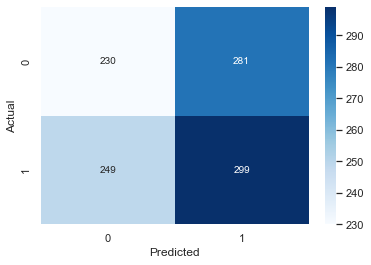

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Create the target variable
# If lookahead_log_return > 0, we consider it a 'Buy' signal (1), otherwise 'Sell' signal (0)
df['Target'] = np.where(df['lookahead_log_return'] > 0, 1, 0)

# Step 3: Select features and target
# Selecting relevant features, excluding lookahead_log_return
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'simple_interest_daily_return']
X = df[features]
y = df['Target']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 5: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

# Step 8: Use the model for future predictions
# Assuming `new_data` is a DataFrame with the same structure as X
# new_data = pd.DataFrame({...})
# predictions = model.predict(new_data)


### LSTM

In [116]:
stock_new= yf.download('AMZN', period='max')
stock_new

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1997-05-15    0.121875    0.125000    0.096354    0.097917    0.097917   
1997-05-16    0.098438    0.098958    0.085417    0.086458    0.086458   
1997-05-19    0.088021    0.088542    0.081250    0.085417    0.085417   
1997-05-20    0.086458    0.087500    0.081771    0.081771    0.081771   
1997-05-21    0.081771    0.082292    0.068750    0.071354    0.071354   
...                ...         ...         ...         ...         ...   
2024-08-16  177.039993  178.339996  176.259995  177.059998  177.059998   
2024-08-19  177.639999  178.300003  176.160004  178.220001  178.220001   
2024-08-20  177.919998  179.009995  177.429993  178.880005  178.880005   
2024-08-21  179.919998  182.389999  178.889999  180.110001  180.110001   
2024-08-22  181.341003  181.470001  178.949997  179.110001  179.110001   

                Volume  
Date                    
1997-05-15  1443120000  
1997-05-16   294000000  
1997-05-19   122136000  
1997-05-20   109344000  
1997-05-21   377064000  
...                ...  
2024-08-16    31489200  
2024-08-19    31129800  
2024-08-20    26255200  
2024-08-21    35109100  
2024-08-22     7012172  

[6863 rows x 6 columns]

In [117]:
df['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

In [130]:
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
# from keras.optimisers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [133]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
# plot_model(lstm, show_shapes=True, show_layer_names=True)


history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
402/402 [==============================] - 6s 5ms/step - loss: 10487.1094
Epoch 2/100
402/402 [==============================] - 2s 6ms/step - loss: 8637.1143
Epoch 3/100
402/402 [==============================] - 3s 6ms/step - loss: 6747.5571
Epoch 4/100
402/402 [==============================] - 2s 6ms/step - loss: 5078.4219
Epoch 5/100
402/402 [==============================] - 3s 7ms/step - loss: 3810.1160
Epoch 6/100
402/402 [==============================] - 3s 6ms/step - loss: 2894.3909
Epoch 7/100
402/402 [==============================] - 3s 6ms/step - loss: 2191.4788
Epoch 8/100
402/402 [==============================] - 3s 7ms/step - loss: 1601.4120
Epoch 9/100
402/402 [==============================] - 3s 8ms/step - loss: 1101.3092
Epoch 10/100
402/402 [==============================] - 3s 7ms/step - loss: 706.3220
Epoch 11/100
402/402 [==============================] - 3s 7ms/step - loss: 425.2212
Epoch 12/100
402/402 [==============================] - 1s 3ms/s

In [134]:
y_pred= lstm.predict(X_test)

11/11 [==============================] - 1s 4ms/step


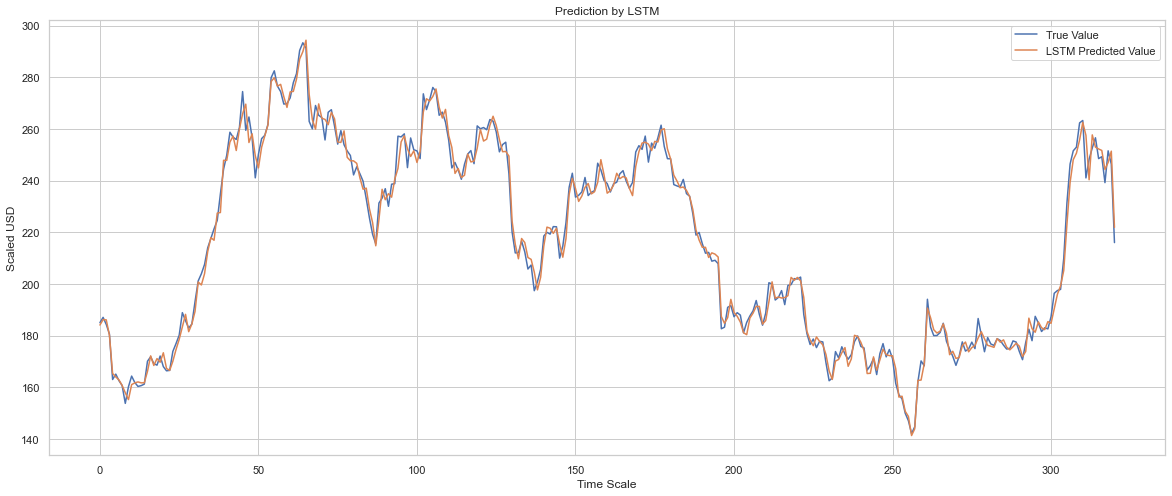

In [145]:
#Predicted vs True Adj Close Value – LSTM
plt.figure(figsize=(20, 8))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Predicted Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()